# 概要
100枚の画像だけで作ったモデルによる推論によって、ラベルなしデータからどれだけラベルをつけていいか検討する。

ラベルなしデータを正解、不正解にわけ、スコアの分布を調べる

In [2]:
import keras
import keras.backend as K
from keras.datasets import cifar10
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [3]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
size_factor = int(224/32) # resnet 224 x 224, cifar10 32 x 32
X_train = K.resize_images(X_train[0:100], size_factor, size_factor, data_format="channels_last").numpy()
Y_train = Y_train[0:100]
X_test = K.resize_images(X_test[0:1000], size_factor, size_factor, data_format="channels_last").numpy()
Y_test = Y_test[0:1000]

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
model = keras.models.load_model('epoch20_adam.h5', compile=False)

In [4]:
predictions = model.predict(X_test, batch_size=128, verbose=1)

1000/1000 [==============================] - 150s 150ms/step


In [5]:
predictions.shape

(1000, 10)

In [8]:
np.save('epoch20_adam_pred',predictions)

In [4]:
predictions = np.load('epoch20_adam_pred.npy')

In [5]:
df = pd.DataFrame()
df['score'] = np.max(predictions,axis=1)
df['predicted_label'] = np.argmax(predictions,axis=1)
df['grand_truth'] = Y_test
df['result'] = np.expand_dims(np.argmax(predictions,axis=1),1) == Y_test

In [6]:
df.describe()

,score,predicted_label,grand_truth
count,1000.000000,1000.000000,1000.000000
mean,0.398843,5.815000,4.603000
std,0.148102,2.645709,2.910303
min,0.142721,0.000000,0.000000
25%,0.284853,4.000000,2.000000
50%,0.369533,6.000000,5.000000
75%,0.481336,9.000000,7.000000
max,0.957439,9.000000,9.000000


In [7]:
df['result'].value_counts()

False    758
True     242
Name: result, dtype: int64

In [8]:
df[df['result']==True].describe()

,score,predicted_label,grand_truth
count,242.000000,242.000000,242.000000
mean,0.444237,5.826446,5.826446
std,0.146974,2.670502,2.670502
min,0.171971,0.000000,0.000000
25%,0.336220,4.000000,4.000000
50%,0.427207,6.000000,6.000000
75%,0.512533,9.000000,9.000000
max,0.957439,9.000000,9.000000


In [9]:
df[df['result']==False].describe()

,score,predicted_label,grand_truth
count,758.000000,758.000000,758.000000
mean,0.384350,5.811346,4.212401
std,0.145602,2.639508,2.876774
min,0.142721,0.000000,0.000000
25%,0.273073,4.000000,2.000000
50%,0.351970,6.000000,4.000000
75%,0.460494,9.000000,7.000000
max,0.930634,9.000000,9.000000


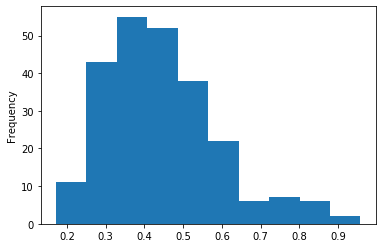

In [10]:
df[df['result']==True]['score'].plot.hist(bins=10)

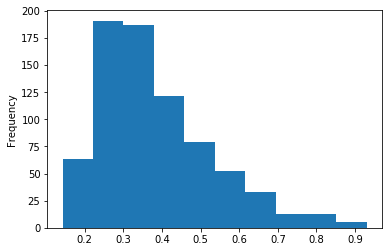

In [11]:
df[df['result']==False]['score'].plot.hist(bins=10)

確かに正解したデータの方が分布が右に偏っている。

In [21]:
df[(df['result']==True)&(df['score']>0.8)].count()

score              8
predicted_label    8
grand_truth        8
result             8
dtype: int64

In [22]:
df[(df['result']==False)&(df['score']>0.8)].count()

score              14
predicted_label    14
grand_truth        14
result             14
dtype: int64

全体では正解:不正解が1:3程度なのに対し、スコア80以上では4:7とかなり正解の割合が増えている。ただし不正解のデータも無視できない割合で存在する